# 第40章: 拡散モデルの実装（基礎編）

## 📋 この章で学ぶこと

この章を終えると、以下ができるようになります：

- [ ] DDPMを完全に実装できる
- [ ] MNISTで拡散モデルを訓練できる
- [ ] サンプリングプロセスを実装できる
- [ ] 生成画像の品質を評価できる

## 🎯 前提知識

この章を学ぶには以下の知識が必要です：

- ✅ Notebook 37-38（拡散モデル理論）
- ✅ Notebook 39（U-Netと位置エンコーディング）

⏱️ **推定学習時間**: 180-210分  
📊 **難易度**: ★★★★☆（上級）  
🎓 **カテゴリ**: 実践

---

## 🌟 はじめに

この章では、これまで学んできた理論とコンポーネントを組み合わせて、**完全な拡散モデル（DDPM）**を実装します。

### 📊 実装の全体像

```
1. ノイズスケジューラ: β_t → α_t → ᾱ_t
2. 前方拡散: q(x_t | x_0) = N(√ᾱ_t x_0, (1-ᾱ_t)I)
3. U-Net: ε_θ(x_t, t) - ノイズを予測
4. 逆方向サンプリング: x_{t-1} ← x_t
```

### 🎯 この章で実装するもの

1. **DDPMクラス**: ノイズスケジュールと拡散プロセスを管理
2. **訓練ループ**: ノイズ予測の学習
3. **サンプリング**: ノイズからの画像生成

In [8]:
# ============================================================
# 環境設定
# ============================================================

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# 日本語フォント設定
import matplotlib.font_manager as fm

def setup_japanese_font():
    japanese_fonts = [
        'Hiragino Sans', 'Hiragino Maru Gothic Pro', 'AppleGothic',
        'Yu Gothic', 'MS Gothic', 'Noto Sans CJK JP', 'IPAexGothic',
    ]
    available_fonts = set(f.name for f in fm.fontManager.ttflist)
    for font in japanese_fonts:
        if font in available_fonts:
            plt.rcParams['font.family'] = font
            plt.rcParams['axes.unicode_minus'] = False
            return font
    return None

font_used = setup_japanese_font()
if font_used:
    print(f"日本語フォント: {font_used}")

device = torch.device('cuda' if torch.cuda.is_available() else 
                      'mps' if torch.backends.mps.is_available() else 'cpu')

torch.manual_seed(42)
np.random.seed(42)

print(f"Device: {device}")
print("✅ ライブラリのインポート完了")

日本語フォント: Hiragino Sans
Device: mps
✅ ライブラリのインポート完了


---

## 1. U-Netの実装（Notebook 39から再掲）

In [9]:
# ============================================================
# U-Netコンポーネント
# ============================================================

class SinusoidalPositionEmbedding(nn.Module):
    """正弦波位置エンコーディング"""
    
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
    
    def forward(self, t):
        device = t.device
        half_dim = self.dim // 2
        embeddings = np.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = t[:, None] * embeddings[None, :]
        embeddings = torch.cat([torch.sin(embeddings), torch.cos(embeddings)], dim=-1)
        return embeddings


class TimeConditionedConvBlock(nn.Module):
    """タイムステップ条件付き畳み込みブロック"""
    
    def __init__(self, in_channels, out_channels, time_dim, num_groups=8):
        super().__init__()
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.norm1 = nn.GroupNorm(num_groups, out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.norm2 = nn.GroupNorm(num_groups, out_channels)
        self.activation = nn.SiLU()
        
        self.time_mlp = nn.Sequential(
            nn.SiLU(),
            nn.Linear(time_dim, out_channels),
        )
        
        if in_channels != out_channels:
            self.residual_conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        else:
            self.residual_conv = nn.Identity()
    
    def forward(self, x, t_emb):
        residual = self.residual_conv(x)
        
        x = self.conv1(x)
        x = self.norm1(x)
        x = self.activation(x)
        
        t_emb = self.time_mlp(t_emb)
        t_emb = t_emb[:, :, None, None]
        x = x + t_emb
        
        x = self.conv2(x)
        x = self.norm2(x)
        x = self.activation(x)
        
        return x + residual


class Downsample(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv = nn.Conv2d(channels, channels, kernel_size=3, stride=2, padding=1)
    
    def forward(self, x):
        return self.conv(x)


class Upsample(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
    
    def forward(self, x):
        x = F.interpolate(x, scale_factor=2, mode='nearest')
        return self.conv(x)


class SimpleUNet(nn.Module):
    """拡散モデル用のシンプルなU-Net"""
    
    def __init__(self, in_channels=1, out_channels=1, time_dim=128, 
                 base_channels=64, channel_mults=(1, 2, 4)):
        super().__init__()
        
        self.time_dim = time_dim
        
        self.time_embed = nn.Sequential(
            SinusoidalPositionEmbedding(time_dim),
            nn.Linear(time_dim, time_dim * 4),
            nn.SiLU(),
            nn.Linear(time_dim * 4, time_dim),
        )
        
        self.init_conv = nn.Conv2d(in_channels, base_channels, kernel_size=3, padding=1)
        
        self.down_blocks = nn.ModuleList()
        self.down_samples = nn.ModuleList()
        
        channels = [base_channels * m for m in channel_mults]
        in_ch = base_channels
        
        for i, out_ch in enumerate(channels):
            self.down_blocks.append(
                TimeConditionedConvBlock(in_ch, out_ch, time_dim)
            )
            if i < len(channels) - 1:
                self.down_samples.append(Downsample(out_ch))
            in_ch = out_ch
        
        self.mid_block = TimeConditionedConvBlock(channels[-1], channels[-1], time_dim)
        
        self.up_samples = nn.ModuleList()
        self.up_blocks = nn.ModuleList()
        
        reversed_channels = list(reversed(channels))
        
        for i, out_ch in enumerate(reversed_channels):
            if i == 0:
                in_ch = reversed_channels[0]
            else:
                in_ch = reversed_channels[i-1] + channels[len(channels)-1-i]
            if i > 0:
                self.up_samples.append(Upsample(reversed_channels[i-1]))
            self.up_blocks.append(
                TimeConditionedConvBlock(in_ch, out_ch, time_dim)
            )
        
        self.final_conv = nn.Sequential(
            nn.GroupNorm(8, base_channels),
            nn.SiLU(),
            nn.Conv2d(base_channels, out_channels, kernel_size=3, padding=1),
        )
    
    def forward(self, x, t):
        t_emb = self.time_embed(t.float())
        x = self.init_conv(x)
        
        skip_connections = []
        for i, block in enumerate(self.down_blocks):
            x = block(x, t_emb)
            skip_connections.append(x)
            if i < len(self.down_samples):
                x = self.down_samples[i](x)
        
        x = self.mid_block(x, t_emb)
        
        for i, block in enumerate(self.up_blocks):
            if i > 0:
                x = self.up_samples[i-1](x)
                skip = skip_connections[-(i+1)]
                x = torch.cat([x, skip], dim=1)
            x = block(x, t_emb)
        
        return self.final_conv(x)

print("✅ U-Netを定義しました")

✅ U-Netを定義しました


---

## 2. DDPMクラスの実装

ノイズスケジュール、前方拡散、逆方向サンプリングを1つのクラスにまとめます。

In [10]:
# ============================================================
# DDPMクラス
# ============================================================

class DDPM:
    """
    Denoising Diffusion Probabilistic Models
    
    ノイズスケジュール、前方拡散、逆方向サンプリングを管理
    """
    
    def __init__(self, model, T=1000, beta_start=1e-4, beta_end=0.02, device='cpu'):
        """
        Parameters:
        -----------
        model : nn.Module
            ノイズ予測ネットワーク（U-Net）
        T : int
            総タイムステップ数
        beta_start, beta_end : float
            線形ノイズスケジュールの開始・終了値
        device : str
            計算デバイス
        """
        self.model = model
        self.T = T
        self.device = device
        
        # ノイズスケジュールを計算
        self.betas = torch.linspace(beta_start, beta_end, T).to(device)
        self.alphas = 1 - self.betas
        self.alpha_bars = torch.cumprod(self.alphas, dim=0)
        
        # 逆方向サンプリング用の係数
        self.alpha_bars_prev = F.pad(self.alpha_bars[:-1], (1, 0), value=1.0)
        
        # 事後分布 q(x_{t-1} | x_t, x_0) のパラメータ
        self.posterior_variance = self.betas * (1 - self.alpha_bars_prev) / (1 - self.alpha_bars)
        self.posterior_mean_coef1 = self.betas * torch.sqrt(self.alpha_bars_prev) / (1 - self.alpha_bars)
        self.posterior_mean_coef2 = (1 - self.alpha_bars_prev) * torch.sqrt(self.alphas) / (1 - self.alpha_bars)
    
    def q_sample(self, x_0, t, noise=None):
        """
        前方拡散: q(x_t | x_0)
        
        x_t = √ᾱ_t * x_0 + √(1-ᾱ_t) * ε
        """
        if noise is None:
            noise = torch.randn_like(x_0)
        
        alpha_bar_t = self.alpha_bars[t].view(-1, 1, 1, 1)
        
        x_t = torch.sqrt(alpha_bar_t) * x_0 + torch.sqrt(1 - alpha_bar_t) * noise
        
        return x_t, noise
    
    def compute_loss(self, x_0):
        """
        訓練損失を計算
        
        L = E_{t, ε}[||ε - ε_θ(x_t, t)||²]
        """
        batch_size = x_0.shape[0]
        
        # ランダムなタイムステップ
        t = torch.randint(0, self.T, (batch_size,), device=self.device)
        
        # 前方拡散
        x_t, noise = self.q_sample(x_0, t)
        
        # ノイズを予測
        noise_pred = self.model(x_t, t)
        
        # MSE損失
        loss = F.mse_loss(noise_pred, noise)
        
        return loss
    
    @torch.no_grad()
    def p_sample(self, x_t, t):
        """
        1ステップの逆方向サンプリング: p_θ(x_{t-1} | x_t)
        """
        # 現在のタイムステップでの係数
        alpha_t = self.alphas[t]
        alpha_bar_t = self.alpha_bars[t]
        beta_t = self.betas[t]
        
        # ノイズを予測
        t_tensor = torch.full((x_t.shape[0],), t, device=self.device, dtype=torch.long)
        noise_pred = self.model(x_t, t_tensor)
        
        # 平均を計算
        # μ_θ = (1/√α_t) * (x_t - (β_t/√(1-ᾱ_t)) * ε_θ)
        mean = (1 / torch.sqrt(alpha_t)) * (
            x_t - (beta_t / torch.sqrt(1 - alpha_bar_t)) * noise_pred
        )
        
        if t > 0:
            # ノイズを追加（t > 0 の場合のみ）
            noise = torch.randn_like(x_t)
            sigma_t = torch.sqrt(self.posterior_variance[t])
            x_prev = mean + sigma_t * noise
        else:
            x_prev = mean
        
        return x_prev
    
    @torch.no_grad()
    def sample(self, shape, return_all_steps=False):
        """
        完全なサンプリングプロセス
        
        x_T ~ N(0, I) から開始して x_0 を生成
        """
        # ノイズから開始
        x = torch.randn(shape, device=self.device)
        
        if return_all_steps:
            all_steps = [x.cpu()]
        
        # T から 0 まで逆方向にサンプリング
        for t in tqdm(reversed(range(self.T)), total=self.T, desc='Sampling'):
            x = self.p_sample(x, t)
            
            if return_all_steps:
                all_steps.append(x.cpu())
        
        if return_all_steps:
            return x, all_steps
        return x

print("✅ DDPMクラスを定義しました")

✅ DDPMクラスを定義しました


DDPM構成要素:
  タイムステップ数 T: 1000
  β の範囲: [0.000100, 0.020000]
  α の範囲: [0.999900, 0.980000]
  ᾱ の範囲: [0.999900, 0.000040]


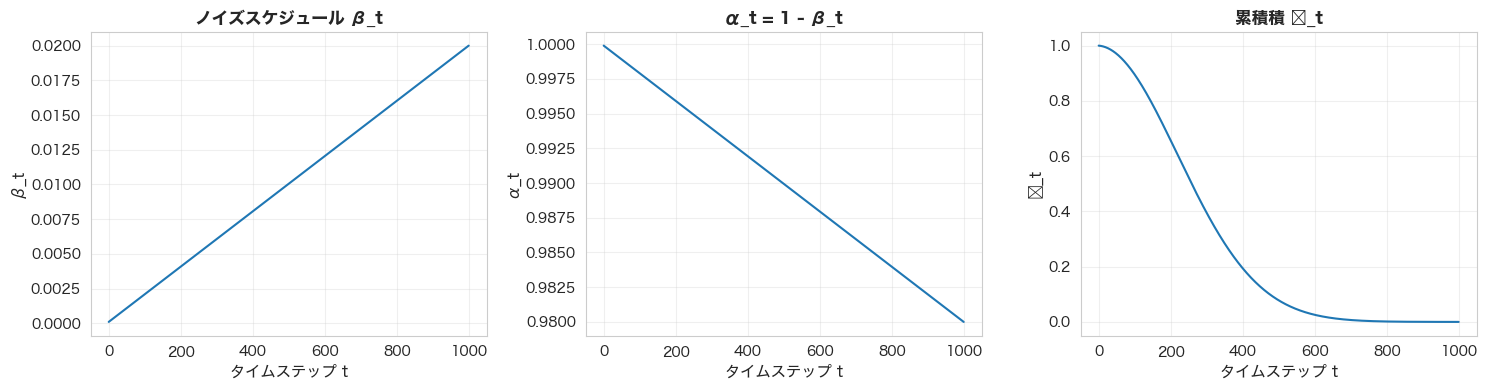

In [11]:
# ============================================================
# DDPMの構成要素を確認
# ============================================================

# テスト用のモデル
model = SimpleUNet(in_channels=1, out_channels=1).to(device)
ddpm = DDPM(model, T=1000, device=device)

print("DDPM構成要素:")
print(f"  タイムステップ数 T: {ddpm.T}")
print(f"  β の範囲: [{ddpm.betas[0]:.6f}, {ddpm.betas[-1]:.6f}]")
print(f"  α の範囲: [{ddpm.alphas[0]:.6f}, {ddpm.alphas[-1]:.6f}]")
print(f"  ᾱ の範囲: [{ddpm.alpha_bars[0]:.6f}, {ddpm.alpha_bars[-1]:.6f}]")

# 可視化
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

t = np.arange(ddpm.T)

axes[0].plot(t, ddpm.betas.cpu().numpy())
axes[0].set_xlabel('タイムステップ t', fontsize=11)
axes[0].set_ylabel('β_t', fontsize=11)
axes[0].set_title('ノイズスケジュール β_t', fontsize=12, fontweight='bold')

axes[1].plot(t, ddpm.alphas.cpu().numpy())
axes[1].set_xlabel('タイムステップ t', fontsize=11)
axes[1].set_ylabel('α_t', fontsize=11)
axes[1].set_title('α_t = 1 - β_t', fontsize=12, fontweight='bold')

axes[2].plot(t, ddpm.alpha_bars.cpu().numpy())
axes[2].set_xlabel('タイムステップ t', fontsize=11)
axes[2].set_ylabel('ᾱ_t', fontsize=11)
axes[2].set_title('累積積 ᾱ_t', fontsize=12, fontweight='bold')

for ax in axes:
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---

## 3. データセットの準備

データセットサイズ: 10,000
バッチサイズ: 128
バッチ数/エポック: 78


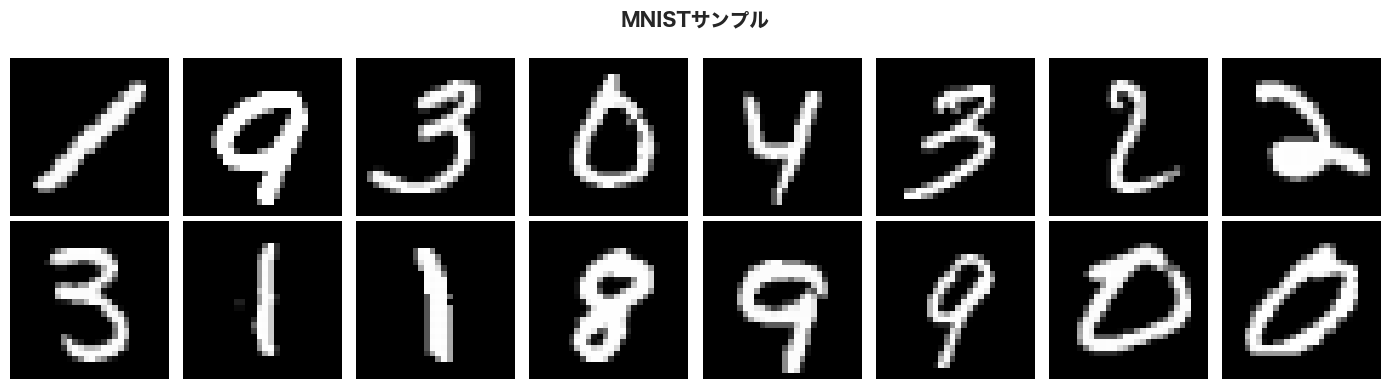

In [12]:
# ============================================================
# MNISTデータセット
# ============================================================

# データを [-1, 1] に正規化
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # [0, 1] -> [-1, 1]
])

# データセット
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# 訓練時間を短縮するため、サブセットを使用（オプション）
# 完全な訓練にはより多くのデータとエポックが必要
subset_size = 10000  # 10,000サンプル
indices = np.random.choice(len(train_dataset), subset_size, replace=False)
train_subset = Subset(train_dataset, indices)

# データローダー
batch_size = 128
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, drop_last=True)

print(f"データセットサイズ: {len(train_subset):,}")
print(f"バッチサイズ: {batch_size}")
print(f"バッチ数/エポック: {len(train_loader)}")

# サンプル画像を表示
sample_batch, _ = next(iter(train_loader))

fig, axes = plt.subplots(2, 8, figsize=(14, 4))
for i, ax in enumerate(axes.flat):
    img = sample_batch[i].squeeze()
    ax.imshow(img.numpy() * 0.5 + 0.5, cmap='gray')  # [-1, 1] -> [0, 1]
    ax.axis('off')
plt.suptitle('MNISTサンプル', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

---

## 4. 訓練

In [13]:
# ============================================================
# 訓練設定
# ============================================================

# モデルとDDPMを初期化
model = SimpleUNet(
    in_channels=1, 
    out_channels=1,
    time_dim=128,
    base_channels=64,
    channel_mults=(1, 2, 4)
).to(device)

ddpm = DDPM(model, T=1000, device=device)

# オプティマイザ
optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)

# 訓練設定
num_epochs = 20  # エポック数（時間に応じて調整）

print(f"モデルパラメータ数: {sum(p.numel() for p in model.parameters()):,}")
print(f"訓練エポック数: {num_epochs}")

モデルパラメータ数: 5,589,953
訓練エポック数: 20


In [14]:
# ============================================================
# 訓練ループ
# ============================================================

losses = []

print("訓練開始...")
print("="*60)

for epoch in range(num_epochs):
    model.train()
    epoch_losses = []
    
    pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}')
    for batch, _ in pbar:
        batch = batch.to(device)
        
        # 損失を計算
        loss = ddpm.compute_loss(batch)
        
        # 最適化
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        
        epoch_losses.append(loss.item())
        pbar.set_postfix({'loss': f'{loss.item():.4f}'})
    
    avg_loss = np.mean(epoch_losses)
    losses.extend(epoch_losses)
    
    print(f"  Epoch {epoch+1}: Loss = {avg_loss:.4f}")

print("="*60)
print("✅ 訓練完了")

訓練開始...


Epoch 1/20:   0%|          | 0/78 [00:00<?, ?it/s]

  Epoch 1: Loss = 0.1447


Epoch 2/20:   0%|          | 0/78 [00:00<?, ?it/s]

  Epoch 2: Loss = 0.0515


Epoch 3/20:   0%|          | 0/78 [00:00<?, ?it/s]

  Epoch 3: Loss = 0.0403


Epoch 4/20:   0%|          | 0/78 [00:00<?, ?it/s]

  Epoch 4: Loss = 0.0379


Epoch 5/20:   0%|          | 0/78 [00:00<?, ?it/s]

  Epoch 5: Loss = 0.0356


Epoch 6/20:   0%|          | 0/78 [00:00<?, ?it/s]

  Epoch 6: Loss = 0.0325


Epoch 7/20:   0%|          | 0/78 [00:00<?, ?it/s]

  Epoch 7: Loss = 0.0316


Epoch 8/20:   0%|          | 0/78 [00:00<?, ?it/s]

  Epoch 8: Loss = 0.0319


Epoch 9/20:   0%|          | 0/78 [00:00<?, ?it/s]

  Epoch 9: Loss = 0.0314


Epoch 10/20:   0%|          | 0/78 [00:00<?, ?it/s]

  Epoch 10: Loss = 0.0292


Epoch 11/20:   0%|          | 0/78 [00:00<?, ?it/s]

  Epoch 11: Loss = 0.0294


Epoch 12/20:   0%|          | 0/78 [00:00<?, ?it/s]

  Epoch 12: Loss = 0.0291


Epoch 13/20:   0%|          | 0/78 [00:00<?, ?it/s]

  Epoch 13: Loss = 0.0283


Epoch 14/20:   0%|          | 0/78 [00:00<?, ?it/s]

  Epoch 14: Loss = 0.0283


Epoch 15/20:   0%|          | 0/78 [00:00<?, ?it/s]

  Epoch 15: Loss = 0.0263


Epoch 16/20:   0%|          | 0/78 [00:00<?, ?it/s]

  Epoch 16: Loss = 0.0268


Epoch 17/20:   0%|          | 0/78 [00:00<?, ?it/s]

  Epoch 17: Loss = 0.0267


Epoch 18/20:   0%|          | 0/78 [00:00<?, ?it/s]

  Epoch 18: Loss = 0.0264


Epoch 19/20:   0%|          | 0/78 [00:00<?, ?it/s]

  Epoch 19: Loss = 0.0255


Epoch 20/20:   0%|          | 0/78 [00:00<?, ?it/s]

  Epoch 20: Loss = 0.0259
✅ 訓練完了


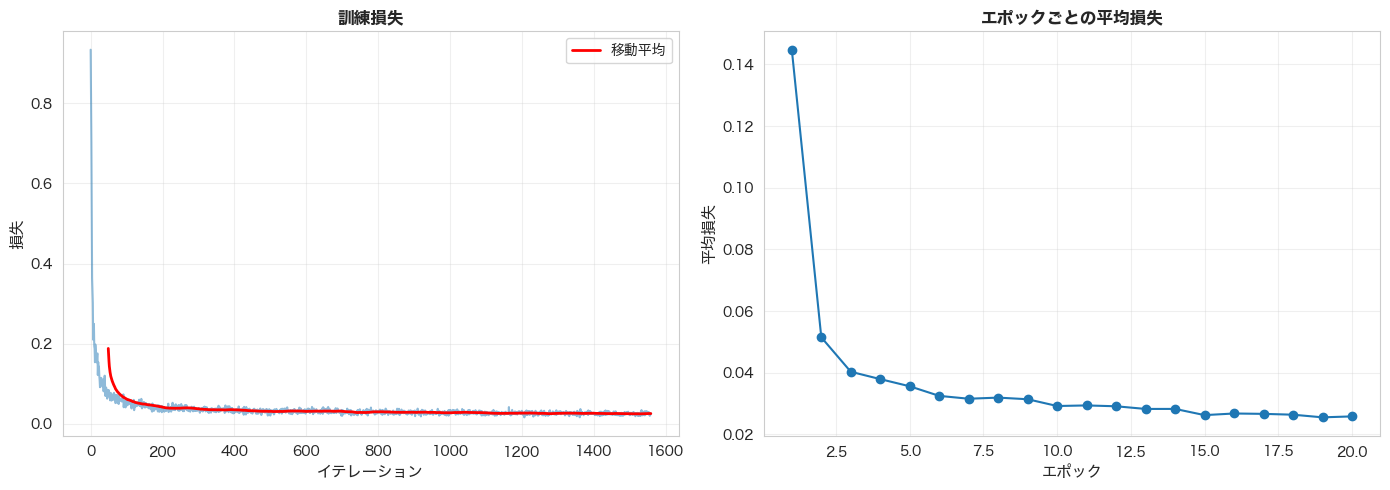

In [15]:
# ============================================================
# 訓練曲線
# ============================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 全損失
axes[0].plot(losses, alpha=0.5)
# 移動平均
window = 50
if len(losses) > window:
    moving_avg = np.convolve(losses, np.ones(window)/window, mode='valid')
    axes[0].plot(range(window-1, len(losses)), moving_avg, color='red', linewidth=2, label='移動平均')
axes[0].set_xlabel('イテレーション', fontsize=11)
axes[0].set_ylabel('損失', fontsize=11)
axes[0].set_title('訓練損失', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# エポックごとの平均損失
batches_per_epoch = len(train_loader)
epoch_avg_losses = [np.mean(losses[i*batches_per_epoch:(i+1)*batches_per_epoch]) 
                    for i in range(num_epochs)]
axes[1].plot(range(1, num_epochs+1), epoch_avg_losses, marker='o')
axes[1].set_xlabel('エポック', fontsize=11)
axes[1].set_ylabel('平均損失', fontsize=11)
axes[1].set_title('エポックごとの平均損失', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---

## 5. サンプリング（画像生成）

16枚の画像を生成中...


Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

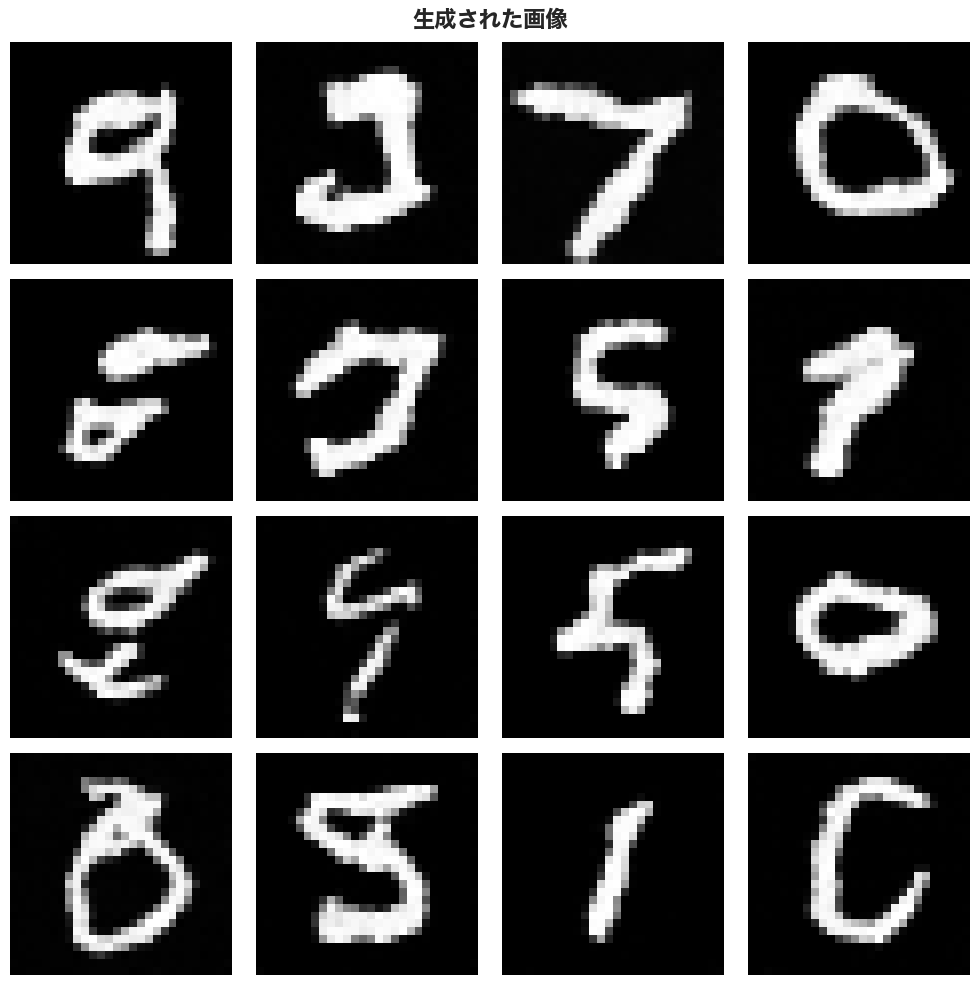

In [16]:
# ============================================================
# サンプル生成
# ============================================================

model.eval()

# 16枚の画像を生成
num_samples = 16
print(f"{num_samples}枚の画像を生成中...")

with torch.no_grad():
    samples = ddpm.sample((num_samples, 1, 28, 28))

# 生成画像を表示
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    img = samples[i].squeeze().cpu().numpy()
    img = np.clip(img * 0.5 + 0.5, 0, 1)  # [-1, 1] -> [0, 1]
    ax.imshow(img, cmap='gray')
    ax.axis('off')

plt.suptitle('生成された画像', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

サンプリングプロセスを可視化...


Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

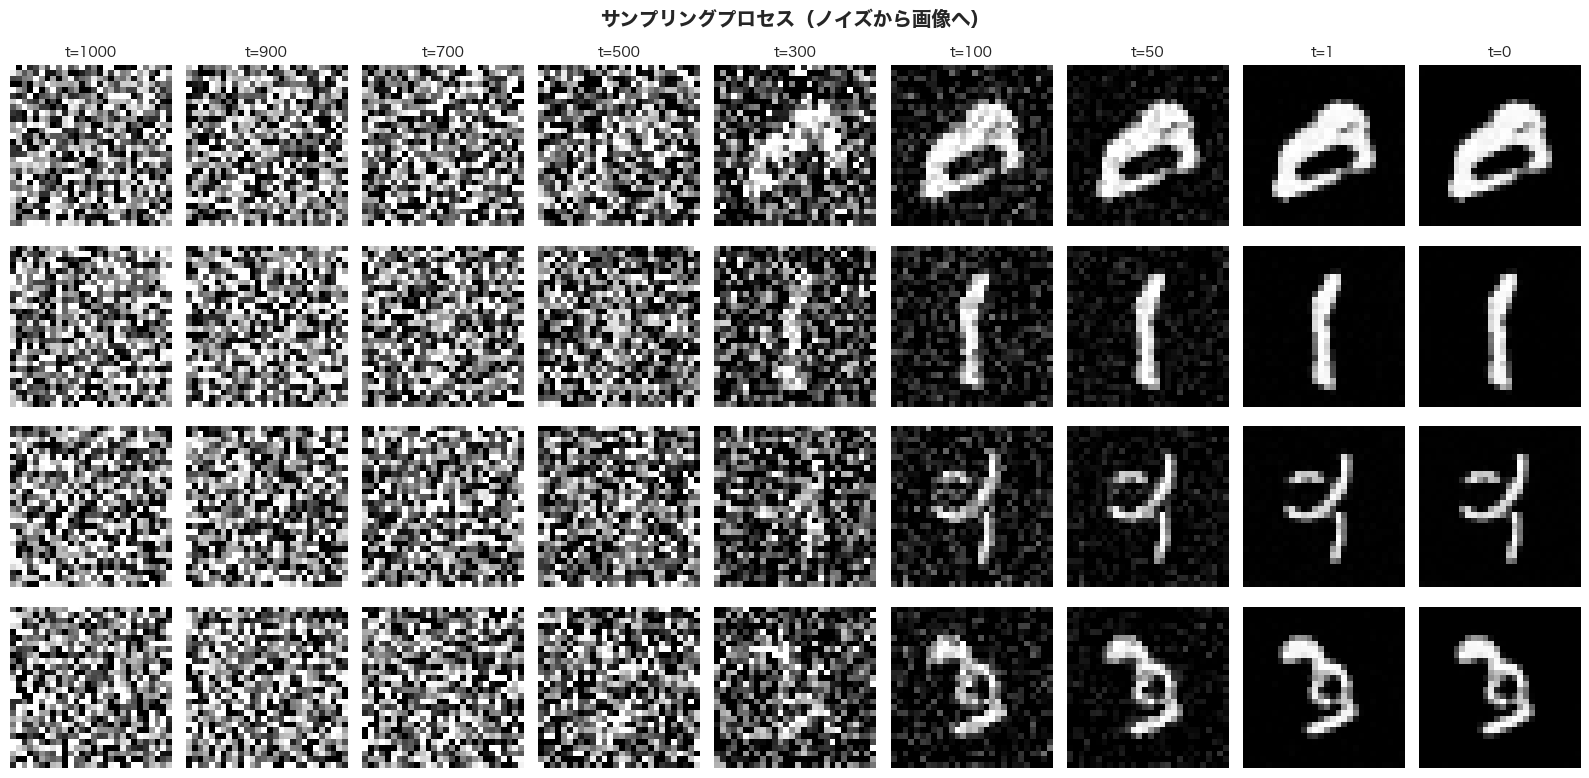

💡 左から右へ: ノイズが徐々に除去され、画像が現れます


In [17]:
# ============================================================
# サンプリングプロセスの可視化
# ============================================================

print("サンプリングプロセスを可視化...")

with torch.no_grad():
    samples, all_steps = ddpm.sample((4, 1, 28, 28), return_all_steps=True)

# 特定のステップを選択
step_indices = [0, 100, 300, 500, 700, 900, 950, 999, 1000]
selected_steps = [all_steps[i] for i in step_indices]

fig, axes = plt.subplots(4, len(step_indices), figsize=(16, 8))

for row in range(4):
    for col, (step_idx, step) in enumerate(zip(step_indices, selected_steps)):
        img = step[row].squeeze().numpy()
        img = np.clip(img * 0.5 + 0.5, 0, 1)
        axes[row, col].imshow(img, cmap='gray')
        axes[row, col].axis('off')
        if row == 0:
            t_label = f't={1000-step_idx}' if step_idx < 1000 else 't=0'
            axes[row, col].set_title(t_label, fontsize=10)

plt.suptitle('サンプリングプロセス（ノイズから画像へ）', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("💡 左から右へ: ノイズが徐々に除去され、画像が現れます")

---

## 6. 生成品質の分析

64枚のサンプルを生成中...


Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

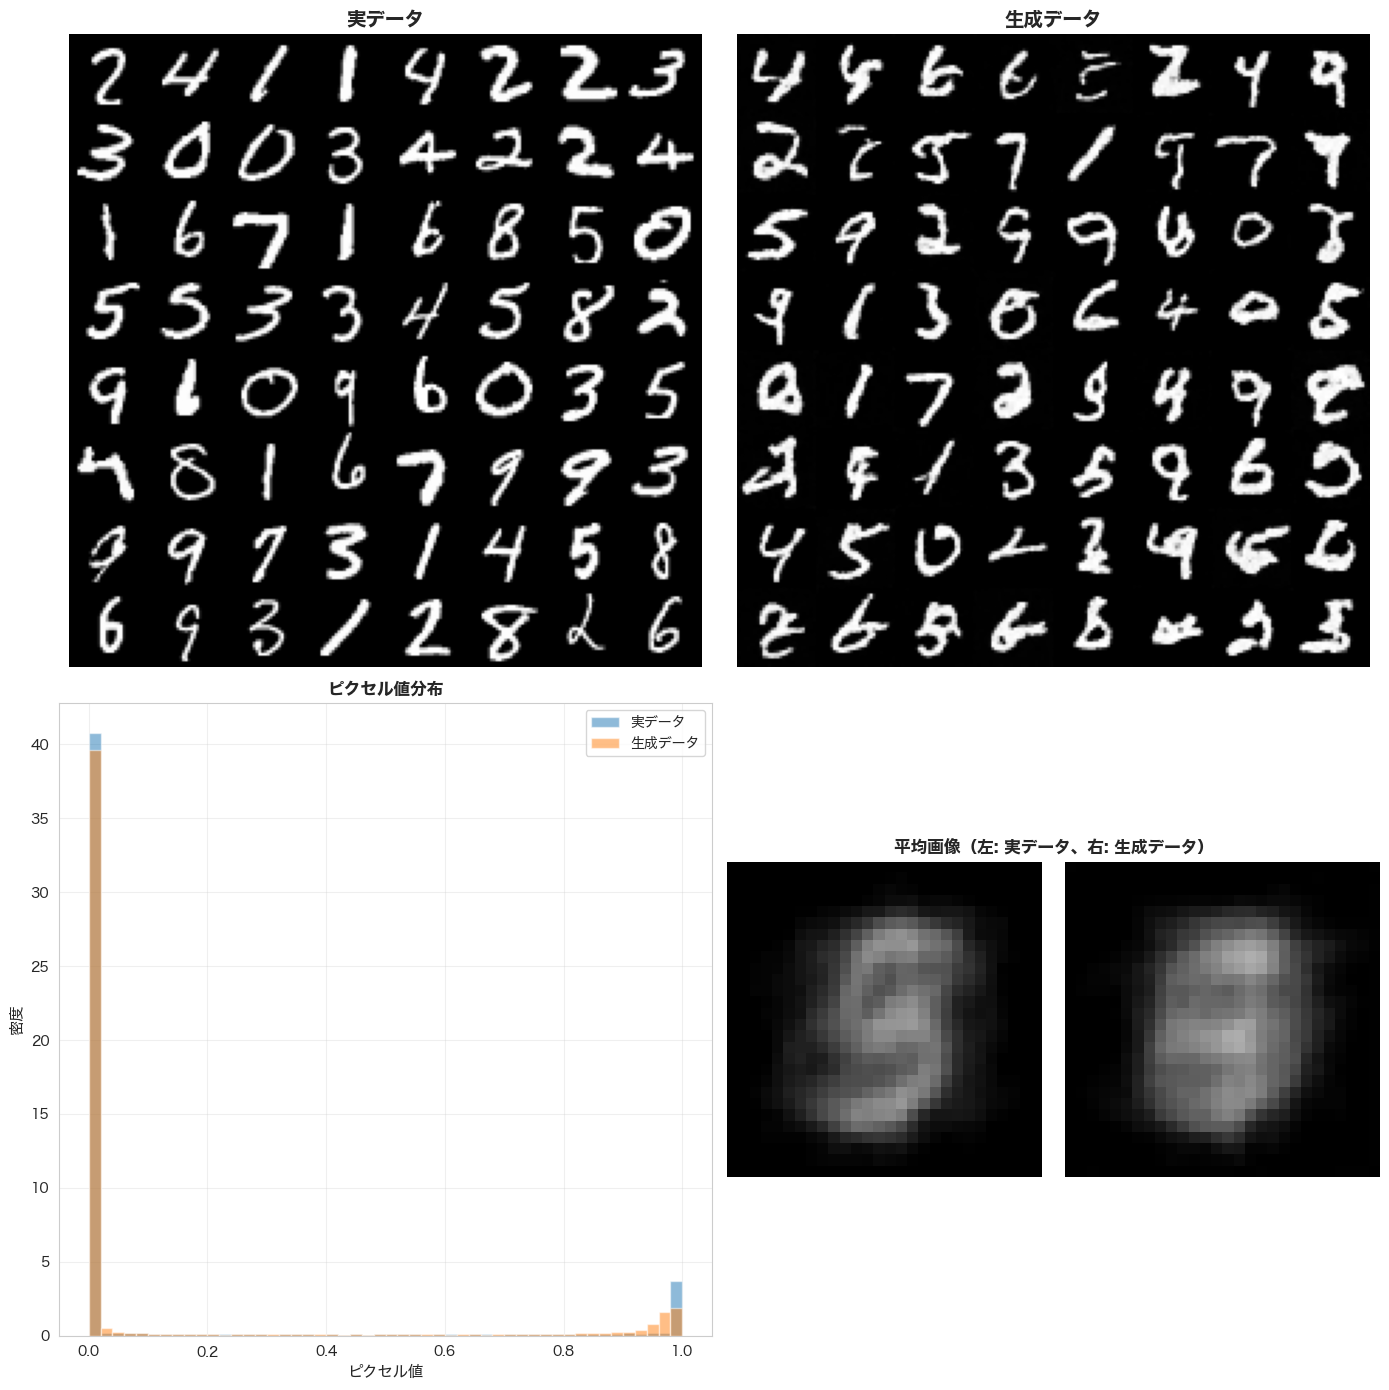

In [18]:
# ============================================================
# 実データとの比較
# ============================================================

# より多くのサンプルを生成
num_samples = 64
print(f"{num_samples}枚のサンプルを生成中...")

with torch.no_grad():
    generated_samples = ddpm.sample((num_samples, 1, 28, 28))

# 実データ
real_samples = next(iter(DataLoader(train_subset, batch_size=num_samples, shuffle=True)))[0]

fig, axes = plt.subplots(2, 2, figsize=(14, 14))

# 実データ
ax = axes[0, 0]
grid_real = torch.zeros(8*28, 8*28)
for i in range(8):
    for j in range(8):
        idx = i * 8 + j
        grid_real[i*28:(i+1)*28, j*28:(j+1)*28] = real_samples[idx].squeeze()
ax.imshow(grid_real.numpy() * 0.5 + 0.5, cmap='gray')
ax.set_title('実データ', fontsize=14, fontweight='bold')
ax.axis('off')

# 生成データ
ax = axes[0, 1]
grid_gen = torch.zeros(8*28, 8*28)
for i in range(8):
    for j in range(8):
        idx = i * 8 + j
        grid_gen[i*28:(i+1)*28, j*28:(j+1)*28] = generated_samples[idx].squeeze().cpu()
ax.imshow(np.clip(grid_gen.numpy() * 0.5 + 0.5, 0, 1), cmap='gray')
ax.set_title('生成データ', fontsize=14, fontweight='bold')
ax.axis('off')

# ピクセル値のヒストグラム
ax = axes[1, 0]
real_flat = (real_samples.numpy() * 0.5 + 0.5).flatten()
gen_flat = np.clip(generated_samples.cpu().numpy() * 0.5 + 0.5, 0, 1).flatten()
ax.hist(real_flat, bins=50, alpha=0.5, label='実データ', density=True)
ax.hist(gen_flat, bins=50, alpha=0.5, label='生成データ', density=True)
ax.set_xlabel('ピクセル値', fontsize=11)
ax.set_ylabel('密度', fontsize=11)
ax.set_title('ピクセル値分布', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# 平均画像
ax = axes[1, 1]
real_mean = real_samples.mean(dim=0).squeeze().numpy() * 0.5 + 0.5
gen_mean = generated_samples.mean(dim=0).squeeze().cpu().numpy() * 0.5 + 0.5

combined = np.concatenate([real_mean, np.ones((28, 2)), gen_mean], axis=1)
ax.imshow(combined, cmap='gray')
ax.set_title('平均画像（左: 実データ、右: 生成データ）', fontsize=12, fontweight='bold')
ax.axis('off')

plt.tight_layout()
plt.show()

---

## まとめ

### 🎯 このノートブックで学んだこと

**DDPMの完全実装**
- ✓ ノイズスケジュール（線形）
- ✓ 前方拡散 q(x_t | x_0)
- ✓ ノイズ予測損失
- ✓ 逆方向サンプリング p_θ(x_{t-1} | x_t)

**訓練と生成**
- ✓ MNISTでの訓練
- ✓ 完全なサンプリングプロセス
- ✓ 生成品質の分析

### 📊 実装したコンポーネント

| コンポーネント | 機能 |
|--------------|------|
| `DDPM.__init__` | ノイズスケジュールの計算 |
| `DDPM.q_sample` | 前方拡散（ノイズ追加） |
| `DDPM.compute_loss` | 訓練損失の計算 |
| `DDPM.p_sample` | 1ステップの逆方向サンプリング |
| `DDPM.sample` | 完全なサンプリングプロセス |

### ⚠️ 改善の余地

- **訓練時間**: より長いエポック数で品質向上
- **サンプリング速度**: 1000ステップは遅い（DDIMで高速化可能）
- **条件付き生成**: 特定の数字を生成できない

---

## 🎓 自己評価クイズ

### Q1: DDPMの訓練目標は何ですか？

<details>
<summary>💡 答えを見る</summary>

**答え**:
ノイズ予測の最小化

$$L = E_{t, x_0, \epsilon}\left[\|\epsilon - \epsilon_\theta(x_t, t)\|^2\right]$$

- ランダムなタイムステップ t をサンプル
- x_0 にノイズ ε を加えて x_t を作成
- ネットワーク ε_θ で ε を予測
- 予測と真のノイズの MSE を最小化

</details>

---

### Q2: サンプリングで t=0 のとき、なぜノイズを追加しないのですか？

<details>
<summary>💡 答えを見る</summary>

**答え**:
- t=0 は最終ステップで、生成される画像 x_0
- x_0 はノイズのない元の画像に対応
- 最終出力にノイズを加えると品質が劣化
- 数学的には、σ_0 = 0（事後分散が0）

</details>

---

### Q3: サンプリングに1000ステップかかる理由は？

<details>
<summary>💡 答えを見る</summary>

**答え**:
- 訓練時に T=1000 ステップでノイズを追加
- 逆方向も同じステップ数が必要
- 各ステップで少しずつノイズを除去
- DDIMなどの手法で高速化可能（次章で扱う）

</details>

---

### ✅ 学習チェックリスト

- [ ] DDPMクラスを自分で実装できる
- [ ] 訓練ループを理解している
- [ ] サンプリングプロセスを説明できる
- [ ] 生成画像の品質を評価できる

---

**次のステップ**: Notebook 41で、**DDIMによる高速サンプリング**と**サンプリング改善テクニック**を学びます！